In [3]:
from diffusers import DiffusionPipeline
import torch
import numpy as np
import random
from PIL import Image
from diffusers.utils import make_image_grid
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
!pip install pandas

#marconb@motox:/mnt/G-SSD/marco_mestrado/artigo_debiasing/sdxl$ 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 58.2 MB/s eta 0:00:00m eta 0:00:010:0101
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 56.5 MB/s eta 0:00:00


Generate Images

In [5]:
# load both base & refiner
base = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    cache_dir='/mnt/G-SSD/marco_mestrado/artigo_debiasing/sdxl_models')
base.to("cuda")
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16",
    cache_dir='/mnt/G-SSD/marco_mestrado/artigo_debiasing/sdxl_models')
refiner.to("cuda")
print('done')

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

model_index.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/4.52G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

done


In [2]:
with open('/home/jordankp/sdxl/cfg_debias_experiment/rnd_list.pkl','rb') as f:
    rnd_list = pickle.load(f)
len(rnd_list)

200

In [12]:
""" OLDER VERSION # gets the list of random seeds used in CFG
for folder in os.listdir('/home/jordankp/sdxl/UI_label_images/labeled_images/'):
    for file in os.listdir('/home/jordankp/sdxl/UI_label_images/labeled_images/'+folder):
        with open('/home/jordankp/sdxl/UI_label_images/labeled_images/'+folder+'/'+file, 'rb') as f:
            imgs_list = pickle.load(f)
        
        if 'df' not in globals():
            df = pd.DataFrame(imgs_list)
        else:
            df = pd.concat([df, pd.DataFrame(imgs_list)], axis=0, ignore_index=True)
df.drop('index', axis=1, inplace=True)
df['orig_deb'] = df['img_path'].str.contains('original').replace(True,'original').replace(False,'debiased')

rnd_list = df['rnd'].unique()
rnd_list.shape"""

(150,)

In [ ]:
# Define Hyper-Parameters
n_steps = 50
high_noise_frac = 0.99
generation_folder = 'firefighter'
prompt = 'the face of firefighter'
guidance_scale = 12
negative_prompt = 'man traits, very manly male man, rougth man, man, male, man, male, man, male'
prompt_eng = 'a single firefighter person, focused on face, female or male' # best prompt engineering to balance a single person between males and females
lookup_prompt = 'the face of a '+ random.choice(['male','female']) +' firefighter'

all_images = []

for seed in rnd_list:
    for mode in range(5):
        if mode==0: # default prompt
            torch.manual_seed(seed)
            image = base(
                prompt=prompt,
                negative_prompt=None,
                num_inference_steps=n_steps,
                denoising_end=high_noise_frac,
                guidance_scale=guidance_scale,
                output_type="latent"
            ).images
            image_default = refiner(
                prompt=prompt,
                negative_prompt=None,
                num_inference_steps=n_steps,
                denoising_start=high_noise_frac,
                image=image,
                guidance_scale=guidance_scale,
            ).images[0]
        elif mode==1: # negative prompt
            torch.manual_seed(seed)
            image = base(
                prompt=prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=n_steps,
                denoising_end=high_noise_frac,
                guidance_scale=guidance_scale,
                output_type="latent"
            ).images
            image_negative = refiner(
                prompt=prompt,
                negative_prompt=negative_prompt,
                num_inference_steps=n_steps,
                denoising_start=high_noise_frac,
                image=image,
                guidance_scale=guidance_scale,
            ).images[0]
        elif mode==2: # prompt engineering
            torch.manual_seed(seed)
            image = base(
                prompt=prompt_eng,
                negative_prompt=None,
                num_inference_steps=n_steps,
                denoising_end=high_noise_frac,
                guidance_scale=guidance_scale,
                output_type="latent"
            ).images
            image_prompt_eng = refiner(
                prompt=prompt_eng,
                negative_prompt=None,
                num_inference_steps=n_steps,
                denoising_start=high_noise_frac,
                image=image,
                guidance_scale=guidance_scale,
            ).images[0]
        elif mode==3: # Lookup table
            torch.manual_seed(seed)
            image = base(
                prompt=lookup_prompt,
                negative_prompt=None,
                num_inference_steps=n_steps,
                denoising_end=high_noise_frac,
                guidance_scale=guidance_scale,
                output_type="latent"
            ).images
            image_lookup_table = refiner(
                prompt=lookup_prompt,
                negative_prompt=None,
                num_inference_steps=n_steps,
                denoising_start=high_noise_frac,
                image=image,
                guidance_scale=guidance_scale,
            ).images[0]
        elif mode==4:
            image_cfg = Image.open(
                '/home/jordankp/sdxl/UI_label_images/static/images/'+
                generation_folder+'/'+
                generation_folder+'_debiased_'
                +str(seed)+'.jpg')
    all_images.append([seed,image_default,image_cfg,image_negative,image_prompt_eng,image_lookup_table])

# Save list of images as a pickle file
#with open('./all_images.pkl', 'wb') as file:
#    pickle.dump(all_images, file)

Load All Images from Multiple Methods into Memory

In [18]:
# Load list of images from a pickle file
with open('./all_images.pkl', 'rb') as file:
    all_images = pickle.load(file)

Plot Image Grids

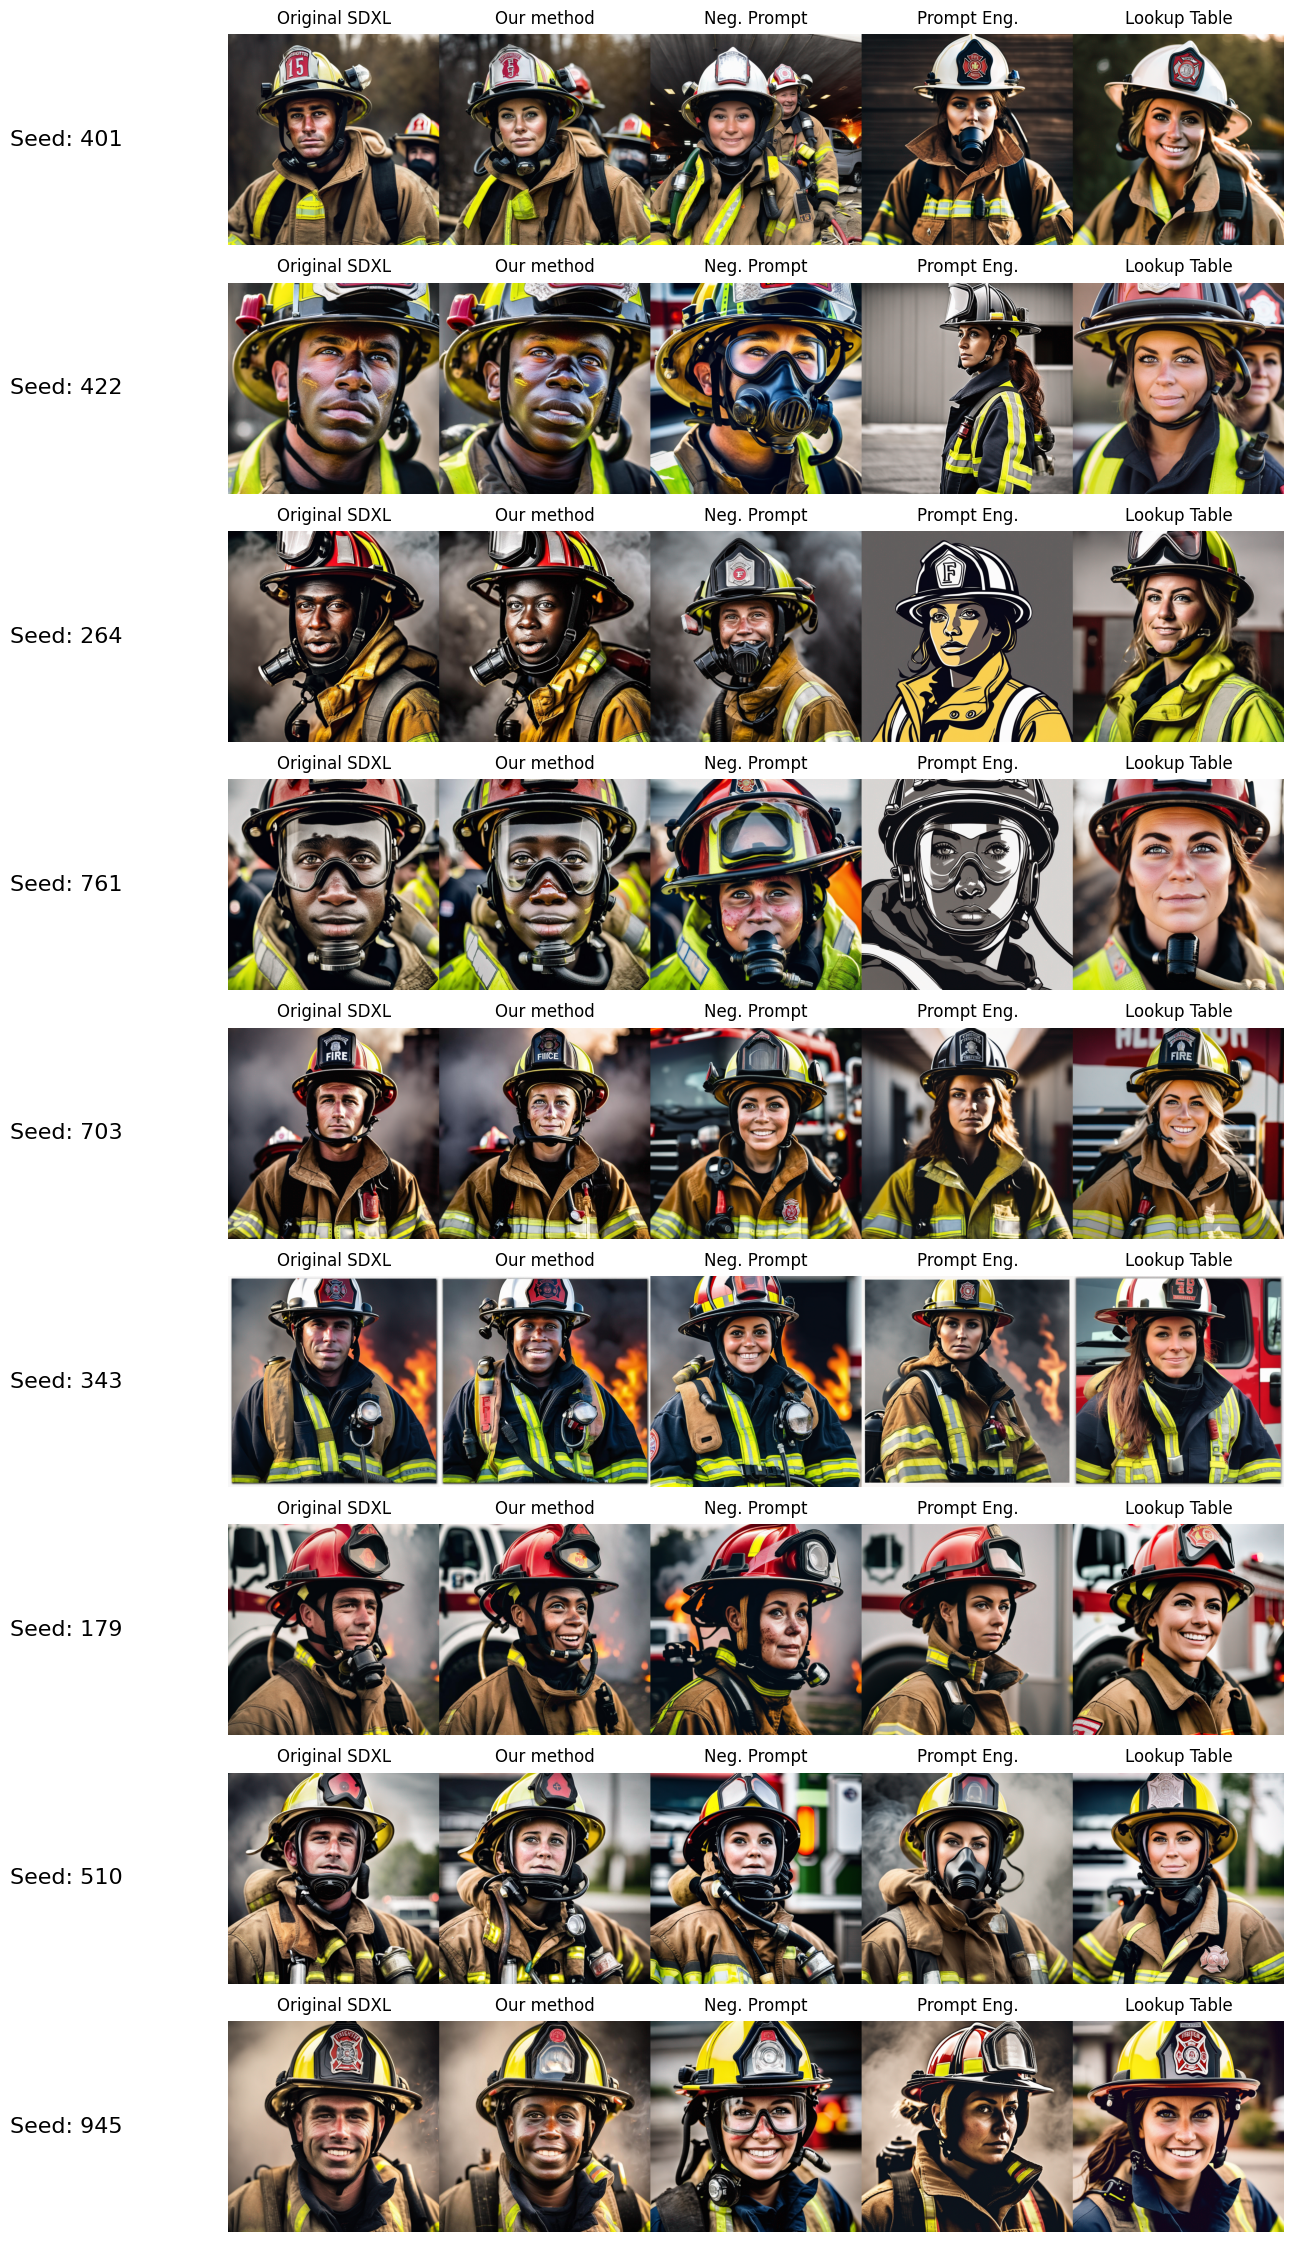

In [50]:
# Plot images on grid for each seed
num_samples = 9 #len(all_images)
fig, axs = plt.subplots(num_samples, 1, figsize=(30, 2.5*num_samples))
axs = axs.flatten()

#random.shuffle(all_images)
subset_imgs = []
for img in all_images:
    if img[0] in [510, 703, 401, 761, 179, 264, 422, 945, 343]:
        subset_imgs.append(img)

for i in range(num_samples):
    grid = make_image_grid(subset_imgs[i][1:], rows=1, cols=5)
    label = subset_imgs[i][0]
    
    axs[i].imshow(grid)
    axs[i].axis("off")
    axs[i].text(-0.1, 0.5, 'Seed: '+str(label), fontsize=16, va="center", ha="right",
            transform=axs[i].transAxes)
    
    # Add text descriptions for each column
    for j, desc in enumerate(['Original SDXL', 'Our method', 'Neg. Prompt', 'Prompt Eng.', 'Lookup Table']):
        axs[i].text(j * (1/5) + 0.1, 1.05, desc, fontsize=12, ha="center",
                    transform=axs[i].transAxes)
    
plt.tight_layout()
plt.show()

Measures Cosine Similarity between Methods

In [4]:
def cosine_similarity_between_images(image1, image2):
    img_vector1 = np.array(image1).flatten().reshape(1,-1)
    img_vector2 = np.array(image2).flatten().reshape(1,-1)

    similarity = cosine_similarity(img_vector1, img_vector2)[0, 0]
    return similarity

def cos_sim_on_grid(list_of_images_w_seed):
    cfg_cos_sim = []
    neg_promp_cos_sim = []
    promp_eng_cos_sim = []
    lookup_tbl_cos_sim = []

    for i in range(len(list_of_images_w_seed)):
        cfg_cos_sim.append(cosine_similarity_between_images(list_of_images_w_seed[i][1], list_of_images_w_seed[i][2]))
        neg_promp_cos_sim.append(cosine_similarity_between_images(list_of_images_w_seed[i][1], list_of_images_w_seed[i][3]))
        promp_eng_cos_sim.append(cosine_similarity_between_images(list_of_images_w_seed[i][1], list_of_images_w_seed[i][4]))
        lookup_tbl_cos_sim.append(cosine_similarity_between_images(list_of_images_w_seed[i][1], list_of_images_w_seed[i][5]))

    return cfg_cos_sim, neg_promp_cos_sim, promp_eng_cos_sim, lookup_tbl_cos_sim

In [5]:
# Similaridade do Cosseno para toda a lista de imagens:
cfg_cos_sim, neg_promp_zcos_sim, promp_eng_cos_sim, lookup_tbl_cos_sim = cos_sim_on_grid(all_images)
print(f'''
ClassFreeG: avg= {np.mean(cfg_cos_sim)*100} | std= {np.std(cfg_cos_sim)}
Neg Prompt: avg= {np.mean(neg_promp_cos_sim)*100}  | std= {np.std(neg_promp_cos_sim)}
Prompt Eng: avg= {np.mean(promp_eng_cos_sim)*100} | std= {np.std(promp_eng_cos_sim)}
Lookup Tbl: avg= {np.mean(lookup_tbl_cos_sim)*100} | std= {np.std(lookup_tbl_cos_sim)}''')


ClassFreeG: avg= 95.15545412218431 | std= 0.017296698198170816
Neg Prompt: avg= 85.80137219207182  | std= 0.055152264483597835
Prompt Eng: avg= 84.26585306693346 | std= 0.061538479352541246
Lookup Tbl: avg= 84.18091803291232 | std= 0.049374152764213294


Average Image Comparison

In [20]:
# Average Image of each Method
def avg_images_by_method(list_of_images_w_seed):
    imgs_default = [img[1] for img in list_of_images_w_seed]
    imgs_cfg = [img[2] for img in list_of_images_w_seed]
    imgs_neg_prompt = [img[3] for img in list_of_images_w_seed]
    imgs_prompt_eng = [img[4] for img in list_of_images_w_seed]
    imgs_lookup_tbl = [img[5] for img in list_of_images_w_seed]

    avg_img_default = np.array(imgs_default).sum(axis=0) / np.array(imgs_default).shape[0]
    avg_img_cfg = np.array(imgs_cfg).sum(axis=0) / np.array(imgs_cfg).shape[0]
    avg_img_neg_prompt = np.array(imgs_neg_prompt).sum(axis=0) / np.array(imgs_neg_prompt).shape[0]
    avg_img_prompt_eng = np.array(imgs_prompt_eng).sum(axis=0) / np.array(imgs_prompt_eng).shape[0]
    avg_img_lookup_tbl = np.array(imgs_lookup_tbl).sum(axis=0) / np.array(imgs_lookup_tbl).shape[0]

    return avg_img_default, avg_img_cfg, avg_img_neg_prompt, avg_img_prompt_eng, avg_img_lookup_tbl

In [21]:
avg_img_default, avg_img_cfg, avg_img_neg_prompt, avg_img_prompt_eng, avg_img_lookup_tbl = avg_images_by_method(all_images)

In [22]:
print(f'''Cos Sim between Average Image Default vs Average Image of Methods:
ClassFreeG: {cosine_similarity_between_images(avg_img_default, avg_img_cfg)*100}
Neg Prompt: {cosine_similarity_between_images(avg_img_default, avg_img_neg_prompt)*100}
Prompt Eng: {cosine_similarity_between_images(avg_img_default, avg_img_prompt_eng)*100}
Lookup Tbl: {cosine_similarity_between_images(avg_img_default, avg_img_lookup_tbl)*100}''')

Cos Sim between Average Image Default vs Average Image of Methods:
ClassFreeG: 99.92839044055313
Neg Prompt: 99.68184425292252
Prompt Eng: 99.65887249901667
Lookup Tbl: 99.27443599265472


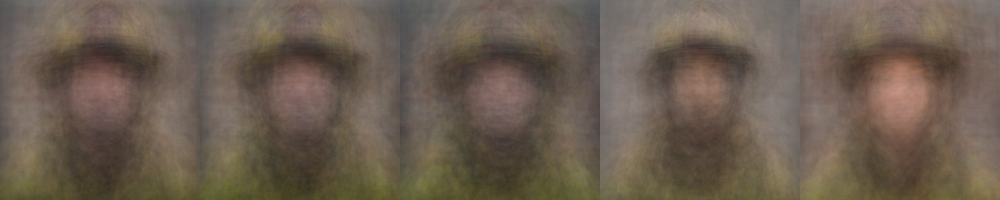

In [23]:
rendered_avg_imgs = []
rendered_avg_imgs.append(Image.fromarray(np.uint8(avg_img_default)))
rendered_avg_imgs.append(Image.fromarray(np.uint8(avg_img_cfg)))
rendered_avg_imgs.append(Image.fromarray(np.uint8(avg_img_neg_prompt)))
rendered_avg_imgs.append(Image.fromarray(np.uint8(avg_img_prompt_eng)))
rendered_avg_imgs.append(Image.fromarray(np.uint8(avg_img_lookup_tbl)))
make_image_grid(rendered_avg_imgs, rows=1, cols=5, resize=200)

Feature Extraction - ResNet-50

In [24]:
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models

In [25]:
def feature_extraction(list_of_images_w_seed):
    # Load pre-trained ResNet model
    resnet_model = models.resnet50(pretrained=True)
    # Remove the classification head (final fully connected layer)
    resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])
    # Set the model to evaluation mode
    resnet_model.eval()
    resnet_model = resnet_model.to('cuda:0')
    print('model done!')

    # Define the image transformation
    # Standard input size for ResNet is (224, 224, 3), and it expects normalized pixel values
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    feature_list = []
    for i in range(len(list_of_images_w_seed)):
        # Load and preprocess the image
        input_image_default = preprocess(list_of_images_w_seed[i][1]).unsqueeze(0).to('cuda:0')
        input_image_cfg = preprocess(list_of_images_w_seed[i][2]).unsqueeze(0).to('cuda:0')
        input_image_neg_prompt = preprocess(list_of_images_w_seed[i][3]).unsqueeze(0).to('cuda:0')
        input_image_prompt_eng = preprocess(list_of_images_w_seed[i][4]).unsqueeze(0).to('cuda:0')
        input_image_lookup_tbl = preprocess(list_of_images_w_seed[i][5]).unsqueeze(0).to('cuda:0')
        
        # Use the model to extract image features, transfer back to cpu and flatten vector
        with torch.no_grad():
            features_default = resnet_model(input_image_default).cpu().flatten().reshape(1,-1)
            features_cfg = resnet_model(input_image_cfg).cpu().flatten().reshape(1,-1)
            features_neg_prompt = resnet_model(input_image_neg_prompt).cpu().flatten().reshape(1,-1)
            features_prompt_eng = resnet_model(input_image_prompt_eng).cpu().flatten().reshape(1,-1)
            features_lookup_tbl = resnet_model(input_image_lookup_tbl).cpu().flatten().reshape(1,-1)
        
        feature_list.append([features_default,features_cfg,features_neg_prompt,features_prompt_eng,features_lookup_tbl])

    return feature_list

In [26]:
def cos_sim_of_features(feature_list):
    cs_feat_cfg = []
    cs_feat_neg_promp = []
    cs_feat_promp_eng = []
    cs_feat_lookup_tbl = []

    for i in range(len(feature_list)):
        cs_feat_cfg.append(cosine_similarity(feature_list[i][0], feature_list[i][1])[0, 0])
        cs_feat_neg_promp.append(cosine_similarity(feature_list[i][0], feature_list[i][2])[0, 0])
        cs_feat_promp_eng.append(cosine_similarity(feature_list[i][0], feature_list[i][3])[0, 0])
        cs_feat_lookup_tbl.append(cosine_similarity(feature_list[i][0], feature_list[i][4])[0, 0])

    return cs_feat_cfg, cs_feat_neg_promp, cs_feat_promp_eng, cs_feat_lookup_tbl

In [28]:
# Similaridade do Cosseno para toda a lista de imagens:
feature_list = feature_extraction(all_images)
cs_feat_cfg, cs_feat_neg_promp, cs_feat_promp_eng, cs_feat_lookup_tbl = cos_sim_of_features(feature_list)

print(f'''\nCosine Similarity of Extracted Features between Default and Debias Methods:
ClassFreeG: avg= {np.mean(cs_feat_cfg)*100} | std= {np.std(cs_feat_cfg)}
Neg Prompt: avg= {np.mean(cs_feat_neg_promp)*100} | std= {np.std(cs_feat_neg_promp)}
Prompt Eng: avg= {np.mean(cs_feat_promp_eng)*100} | std= {np.std(cs_feat_promp_eng)}
Lookup Tbl: avg= {np.mean(cs_feat_lookup_tbl)*100} | std= {np.std(cs_feat_lookup_tbl)}''')

model done!

Cosine Similarity of Extracted Features between Default and Debias Methods:
ClassFreeG: avg= 95.68231701850891 | std= 0.01533178985118866
Neg Prompt: avg= 90.9751296043396 | std= 0.046710629016160965
Prompt Eng: avg= 86.9732677936554 | std= 0.07009494304656982
Lookup Tbl: avg= 87.91446089744568 | std= 0.05152056738734245


Checking Lists on UI Application

In [3]:
with open('/home/jordankp/sdxl/cfg_debias_experiment/debiased_imgs_firefighter.pkl', 'rb') as f:
    debiased_imgs_firefighter = pickle.load(f)
with open('/home/jordankp/sdxl/cfg_debias_experiment/original_imgs_firefighter.pkl', 'rb') as f:
    original_imgs_firefighter = pickle.load(f)

with open('/home/jordankp/sdxl/cfg_debias_experiment/debiased_imgs_nurse.pkl', 'rb') as f:
    debiased_imgs_nurse = pickle.load(f)
with open('/home/jordankp/sdxl/cfg_debias_experiment/original_imgs_nurse.pkl', 'rb') as f:
    original_imgs_nurse = pickle.load(f)

with open('/home/jordankp/sdxl/cfg_debias_experiment/debiased_imgs_business_leader.pkl', 'rb') as f:
    debiased_imgs_business_leader = pickle.load(f)
with open('/home/jordankp/sdxl/cfg_debias_experiment/original_imgs_business_leader.pkl', 'rb') as f:
    original_imgs_business_leader = pickle.load(f)

# load all available images
imgs_list = debiased_imgs_firefighter+original_imgs_firefighter+debiased_imgs_nurse+original_imgs_nurse+debiased_imgs_business_leader+original_imgs_business_leader

In [8]:
len(imgs_list)
imgs_list[899]

{'img_path': '/static/images/business_leader/business_leader_debiased_814.jpg',
 'rnd': 814,
 'prompt': 'the face of a business leader',
 'safety_concept': 'an old man, caucasian, male, man, man, man, male, man, male, man, manly male, man traits',
 'gender': '',
 'ethnicity': '',
 'apparent_age': '',
 'user_name': ''}

In [10]:
analyzed_imgs = []
dir = '/home/jordankp/sdxl/UI_label_images/labeled_images/'+'jordan'+'/'
for file in os.listdir(dir):
    if file.endswith('.pkl'):
        with open(dir+file, 'rb') as f:
            analyzed_imgs.append(pickle.load(f))
len(analyzed_imgs)

32

In [11]:
analyzed_imgs_path = []
for i in range(len(analyzed_imgs)):
    for j in range(len(analyzed_imgs[i])):
        analyzed_imgs_path.append(analyzed_imgs[i][j]['img_path'])
len(analyzed_imgs_path)

960

In [13]:
new_imgs = []
for i in range(len(imgs_list)):
    if imgs_list[i]['img_path'] not in analyzed_imgs_path:
        new_imgs.append(imgs_list[i])
print(len(new_imgs))

under = 0
above = 0
for i in range(len(new_imgs)):
    if new_imgs[i]['rnd'] < 1000:
        under = under + 1
    else:
        above = above + 1
print(under)
print(above)

240
240
0
